# Cross-Encoder Reranker Test for News Threading

Test whether cross-encoder rerankers can capture both **same-story** AND **causal** relationships
between news articles, beyond what bge-base-en-v1.5 cosine similarity provides.

**Two tasks evaluated:**
- `same_story`: Are these articles about the same developing story? (current threading goal)
- `causal`: Does article A's event cause/lead to article B's event? (new capability)

**Models:**
| Model | Type | Size |
|-------|------|------|
| BAAI/bge-base-en-v1.5 | Bi-encoder (baseline) | 109M |
| BAAI/bge-reranker-v2-m3 | Cross-encoder | 568M |
| Qwen3-Reranker-0.6B | CausalLM | 600M |
| tomaarsen/Qwen3-Reranker-0.6B-seq-cls | CrossEncoder class | 600M |

In [1]:
# Cell 1: Setup + DB connection
import gc
import json
import os
import pickle
import time
from collections import defaultdict
from itertools import combinations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from dotenv import load_dotenv
from scipy.special import expit
from sklearn.metrics import (
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    f1_score,
    classification_report,
)
from supabase import create_client

load_dotenv(Path('..') / '.env.local')

url = os.getenv('NEXT_PUBLIC_SUPABASE_URL') or os.getenv('SUPABASE_URL')
key = os.getenv('SUPABASE_SERVICE_ROLE_KEY')
assert url and key, 'Missing Supabase credentials'
supabase = create_client(url, key)

# Device selection
if torch.backends.mps.is_available():
    DEVICE = 'mps'
elif torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

print(f'Connected to Supabase | Device: {DEVICE}')

Connected to Supabase | Device: mps


In [2]:
# Cell 2: Load articles (last 7 days) + embeddings

def paginate_table(table, select_cols, filters=None, page_size=1000):
    """Paginate a Supabase table query."""
    all_rows = []
    offset = 0
    while True:
        q = supabase.table(table).select(select_cols)
        if filters:
            for col, op, val in filters:
                q = q.filter(col, op, val)
        batch = q.range(offset, offset + page_size - 1).execute().data or []
        all_rows.extend(batch)
        if len(batch) < page_size:
            break
        offset += page_size
    return all_rows


from datetime import datetime, timedelta, timezone

cutoff = (datetime.now(timezone.utc) - timedelta(days=7)).isoformat()

# Load wsj_items from last 7 days
item_rows = paginate_table(
    'wsj_items',
    'id, title, description, feed_name, published_at, extracted_entities, extracted_keywords, extracted_tickers, thread_id',
    filters=[('published_at', 'gte', cutoff)],
)
print(f'wsj_items (last 7 days): {len(item_rows)}')

df_items = pd.DataFrame(item_rows)
df_items['published_at'] = pd.to_datetime(df_items['published_at'])

# Build text field
df_items['text'] = df_items['title'] + ' ' + df_items['description'].fillna('')

# Load embeddings for these items
item_ids = df_items['id'].tolist()
emb_rows = []
# Paginate embedding fetch in chunks (Supabase `in` filter limit)
for i in range(0, len(item_ids), 200):
    chunk = item_ids[i:i+200]
    rows = supabase.table('wsj_embeddings') \
        .select('wsj_item_id, embedding') \
        .in_('wsj_item_id', chunk) \
        .execute().data or []
    emb_rows.extend(rows)

print(f'wsj_embeddings loaded: {len(emb_rows)}')

# Build embedding lookup: item_id -> np.array
emb_lookup = {}
for row in emb_rows:
    vec = row['embedding']
    if isinstance(vec, str):
        vec = json.loads(vec)
    emb_lookup[row['wsj_item_id']] = np.array(vec, dtype=np.float32)

# Filter to items that have embeddings
df_items = df_items[df_items['id'].isin(emb_lookup)].reset_index(drop=True)
print(f'Articles with embeddings: {len(df_items)}')
print(f'Feed distribution:\n{df_items["feed_name"].value_counts()}')

wsj_items (last 7 days): 333
wsj_embeddings loaded: 333
Articles with embeddings: 333
Feed distribution:
feed_name
BUSINESS_MARKETS    160
WORLD                57
ECONOMY              47
POLITICS             39
TECH                 30
Name: count, dtype: int64


In [3]:
# Cell 3: Candidate pair generation (pre-filter)
#
# Three nets:
# 1. Entity/ticker overlap (>=1 shared) -> same_story + causal candidates
# 2. Embedding neighbors (bge-base top-10 per article) -> macro chains
# 3. Random negatives (~200 pairs, different category, no overlap)
#
# Rules:
# - Time gate: published_at(A) <= published_at(B) for all pairs
# - Temporal window: <=3 days apart
# - Deduplicate pairs

MAX_DAYS_APART = 3
EMBEDDING_TOP_K = 10
N_RANDOM_NEGATIVES = 200

pairs = set()  # (id_a, id_b) where published_at(A) <= published_at(B)


def add_pair(id_a, id_b, pub_a, pub_b):
    """Add pair with time ordering enforced."""
    if abs((pub_a - pub_b).total_seconds()) > MAX_DAYS_APART * 86400:
        return
    if pub_a <= pub_b:
        pairs.add((id_a, id_b))
    else:
        pairs.add((id_b, id_a))


# --- Net 1: Entity/ticker overlap ---
def get_tags(row):
    entities = set(row.get('extracted_entities') or [])
    tickers = set(row.get('extracted_tickers') or [])
    return entities | tickers

# Build inverted index: tag -> list of item indices
tag_to_indices = defaultdict(list)
for idx, row in df_items.iterrows():
    for tag in get_tags(row):
        tag_to_indices[tag.lower()].append(idx)

entity_pairs = 0
for tag, indices in tag_to_indices.items():
    if len(indices) > 50:  # Skip overly common tags
        continue
    for i, j in combinations(indices, 2):
        add_pair(
            df_items.loc[i, 'id'], df_items.loc[j, 'id'],
            df_items.loc[i, 'published_at'], df_items.loc[j, 'published_at'],
        )
        entity_pairs += 1

print(f'Net 1 (entity/ticker overlap): {entity_pairs} raw pairs -> {len(pairs)} unique after dedup')

# --- Net 2: Embedding neighbors (top-K per article) ---
# Build embedding matrix
item_ids_ordered = df_items['id'].tolist()
emb_matrix = np.stack([emb_lookup[iid] for iid in item_ids_ordered])

# Compute all-pairs cosine similarity
sim_matrix = emb_matrix @ emb_matrix.T

before_net2 = len(pairs)
for i in range(len(item_ids_ordered)):
    # Get top-K neighbors (excluding self)
    sims = sim_matrix[i].copy()
    sims[i] = -1  # exclude self
    top_k_indices = np.argsort(-sims)[:EMBEDDING_TOP_K]
    for j in top_k_indices:
        add_pair(
            item_ids_ordered[i], item_ids_ordered[j],
            df_items.loc[i, 'published_at'], df_items.loc[j, 'published_at'],
        )

print(f'Net 2 (embedding top-{EMBEDDING_TOP_K}): +{len(pairs) - before_net2} new pairs -> {len(pairs)} total')

# --- Net 3: Random negatives ---
rng = np.random.default_rng(42)
before_net3 = len(pairs)
attempts = 0
while len(pairs) - before_net3 < N_RANDOM_NEGATIVES and attempts < N_RANDOM_NEGATIVES * 10:
    i, j = rng.integers(0, len(df_items), size=2)
    attempts += 1
    if i == j:
        continue
    # Different feed_name + no entity overlap
    if df_items.loc[i, 'feed_name'] == df_items.loc[j, 'feed_name']:
        continue
    tags_i = get_tags(df_items.loc[i])
    tags_j = get_tags(df_items.loc[j])
    if tags_i & tags_j:
        continue
    add_pair(
        df_items.loc[i, 'id'], df_items.loc[j, 'id'],
        df_items.loc[i, 'published_at'], df_items.loc[j, 'published_at'],
    )

print(f'Net 3 (random negatives): +{len(pairs) - before_net3} new pairs -> {len(pairs)} total')

# Build pairs DataFrame
pairs_list = list(pairs)
df_pairs = pd.DataFrame(pairs_list, columns=['id_a', 'id_b'])

# Merge article info
items_slim = df_items[['id', 'title', 'description', 'feed_name', 'published_at',
                        'extracted_entities', 'extracted_keywords', 'extracted_tickers']].copy()

df_pairs = df_pairs.merge(items_slim.rename(columns=lambda c: c + '_a' if c != 'id' else 'id_a'),
                          on='id_a', how='left')
df_pairs = df_pairs.merge(items_slim.rename(columns=lambda c: c + '_b' if c != 'id' else 'id_b'),
                          on='id_b', how='left')

# Add bge-base cosine similarity for each pair
id_to_idx = {iid: i for i, iid in enumerate(item_ids_ordered)}
df_pairs['bge_cosine'] = [
    float(sim_matrix[id_to_idx[a], id_to_idx[b]])
    for a, b in zip(df_pairs['id_a'], df_pairs['id_b'])
]

print(f'\nFinal candidate pairs: {len(df_pairs)}')
print(f'bge_cosine stats:\n{df_pairs["bge_cosine"].describe().round(4)}')

Net 1 (entity/ticker overlap): 1171 raw pairs -> 790 unique after dedup
Net 2 (embedding top-10): +1437 new pairs -> 2227 total
Net 3 (random negatives): +200 new pairs -> 2427 total

Final candidate pairs: 2427
bge_cosine stats:
count    2427.0000
mean        0.5903
std         0.0871
min         0.2783
25%         0.5421
50%         0.5903
75%         0.6390
max         1.0000
Name: bge_cosine, dtype: float64


In [6]:
# Cell 4: Gemini Flash labeling (batch approach with strict JSON + CoT)
#
# Groups candidate pairs by shared entities, sends 15-20 articles per batch.
# Labels: same_story (same/related/unrelated), causal (A_causes_B/B_causes_A/no/unclear)

from google import genai

GEMINI_MODEL = 'gemini-2.5-flash'
client = genai.Client(api_key=os.getenv('GEMINI_API_KEY'))

LABEL_PROMPT = """You are a news analyst. For each article pair below, provide two labels:

1. **same_story**: Are these about the same developing news story?
   - "same": Same specific event or direct update (e.g., "Fed raises rates" and "Fed rate decision details")
   - "related": Same topic area but different specific events (e.g., "Fed raises rates" and "ECB holds rates")
   - "unrelated": Different topics entirely

2. **causal**: Does one article's event plausibly cause or lead to the other's?
   - "A_causes_B": Article A's event causes/leads to Article B's event
   - "B_causes_A": Article B's event causes/leads to Article A's event
   - "no": No causal relationship
   - "unclear": Possible but uncertain causal link

IMPORTANT: Article A is always published BEFORE Article B (time-ordered).
Think step-by-step: first explain your reasoning, then provide labels.

Return a JSON array. Each element MUST have this exact structure:
```json
{{
  "article_a_id": "<uuid>",
  "article_b_id": "<uuid>",
  "reasoning": "1-sentence explanation",
  "same_story": "same | related | unrelated",
  "causal": "A_causes_B | B_causes_A | no | unclear"
}}
```

ARTICLES:
{articles_block}

PAIRS TO LABEL:
{pairs_block}
"""


def format_article(row_a_or_b, prefix):
    """Format one article for the prompt."""
    return (
        f"[{prefix}] ID: {row_a_or_b['id']}\n"
        f"  Title: {row_a_or_b['title']}\n"
        f"  Description: {row_a_or_b.get('description', 'N/A')}\n"
        f"  Published: {row_a_or_b['published_at']}\n"
        f"  Category: {row_a_or_b.get('feed_name', 'N/A')}\n"
        f"  Entities: {row_a_or_b.get('extracted_entities', [])}\n"
        f"  Tickers: {row_a_or_b.get('extracted_tickers', [])}"
    )


def build_batches(df_pairs, df_items, max_articles_per_batch=18, max_pairs_per_batch=30):
    """Group pairs into batches, trying to cluster by shared articles."""
    items_lookup = df_items.set_index('id').to_dict('index')
    batches = []
    remaining = list(range(len(df_pairs)))
    
    while remaining:
        batch_indices = []
        batch_article_ids = set()
        
        for idx in remaining[:]:
            row = df_pairs.iloc[idx]
            new_ids = {row['id_a'], row['id_b']} - batch_article_ids
            
            if len(batch_article_ids) + len(new_ids) > max_articles_per_batch:
                if len(batch_indices) >= max_pairs_per_batch:
                    break
                continue
            
            batch_indices.append(idx)
            batch_article_ids.update({row['id_a'], row['id_b']})
            remaining.remove(idx)
            
            if len(batch_indices) >= max_pairs_per_batch:
                break
        
        if not batch_indices:
            # Force-take the first remaining pair
            idx = remaining.pop(0)
            batch_indices = [idx]
            row = df_pairs.iloc[idx]
            batch_article_ids = {row['id_a'], row['id_b']}
        
        # Build prompt
        articles_block = []
        for aid in batch_article_ids:
            if aid in items_lookup:
                info = items_lookup[aid]
                info['id'] = aid
                articles_block.append(format_article(info, aid[:8]))
        
        pairs_block = []
        for idx in batch_indices:
            row = df_pairs.iloc[idx]
            pairs_block.append(f"  Pair: A={row['id_a']} vs B={row['id_b']}")
        
        batches.append({
            'indices': batch_indices,
            'prompt': LABEL_PROMPT.format(
                articles_block='\n\n'.join(articles_block),
                pairs_block='\n'.join(pairs_block),
            ),
        })
    
    return batches


def call_gemini(prompt, retries=2):
    """Call Gemini and parse JSON response."""
    for attempt in range(retries + 1):
        try:
            response = client.models.generate_content(
                model=GEMINI_MODEL,
                contents=prompt,
                config=genai.types.GenerateContentConfig(
                    temperature=0.1,
                    response_mime_type='application/json',
                ),
            )
            text = response.text.strip()
            return json.loads(text)
        except Exception as e:
            if attempt < retries:
                print(f'  Retry {attempt+1}: {e}')
                time.sleep(2 ** attempt)
            else:
                print(f'  FAILED after {retries+1} attempts: {e}')
                return None


# Build batches
batches = build_batches(df_pairs, df_items)
print(f'Total batches: {len(batches)}, total pairs: {len(df_pairs)}')
print(f'Avg pairs/batch: {len(df_pairs) / len(batches):.1f}')

# Run labeling
all_labels = []  # List of dicts from Gemini
failed_batches = []

for i, batch in enumerate(batches):
    print(f'Batch {i+1}/{len(batches)} ({len(batch["indices"])} pairs)...', end=' ')
    result = call_gemini(batch['prompt'])
    
    if result:
        all_labels.extend(result)
        print(f'OK ({len(result)} labels)')
    else:
        failed_batches.append(i)
        print('FAILED')
    
    # Rate limiting
    if i < len(batches) - 1:
        time.sleep(1)

print(f'\nLabeling complete: {len(all_labels)} labels, {len(failed_batches)} failed batches')

# Save to pickle
pickle_path = Path('reranker_causal_labels.pkl')
with open(pickle_path, 'wb') as f:
    pickle.dump({
        'labels': all_labels,
        'df_pairs': df_pairs,
        'df_items': df_items,
        'emb_lookup': emb_lookup,
        'failed_batches': failed_batches,
    }, f)
print(f'Saved to {pickle_path}')

Total batches: 175, total pairs: 2427
Avg pairs/batch: 13.9
Batch 1/175 (19 pairs)... OK (19 labels)
Batch 2/175 (21 pairs)... OK (21 labels)
Batch 3/175 (26 pairs)... OK (26 labels)
Batch 4/175 (23 pairs)... OK (23 labels)
Batch 5/175 (14 pairs)... OK (14 labels)
Batch 6/175 (15 pairs)... OK (15 labels)
Batch 7/175 (17 pairs)... OK (17 labels)
Batch 8/175 (19 pairs)... OK (19 labels)
Batch 9/175 (19 pairs)... OK (19 labels)
Batch 10/175 (18 pairs)... OK (18 labels)
Batch 11/175 (12 pairs)... OK (12 labels)
Batch 12/175 (13 pairs)... OK (13 labels)
Batch 13/175 (16 pairs)... OK (16 labels)
Batch 14/175 (21 pairs)... OK (21 labels)
Batch 15/175 (25 pairs)... OK (25 labels)
Batch 16/175 (16 pairs)... OK (16 labels)
Batch 17/175 (16 pairs)... OK (16 labels)
Batch 18/175 (19 pairs)... OK (19 labels)
Batch 19/175 (30 pairs)... OK (30 labels)
Batch 20/175 (15 pairs)... OK (15 labels)
Batch 21/175 (17 pairs)... OK (17 labels)
Batch 22/175 (23 pairs)... OK (23 labels)
Batch 23/175 (18 pairs)..

In [7]:
# Cell 5: Label quality check

# Parse labels into df_pairs
label_map = {}  # (id_a, id_b) -> label dict
for lbl in all_labels:
    key = (lbl.get('article_a_id'), lbl.get('article_b_id'))
    label_map[key] = lbl

df_pairs['same_story'] = df_pairs.apply(
    lambda r: label_map.get((r['id_a'], r['id_b']), {}).get('same_story', 'missing'), axis=1
)
df_pairs['causal'] = df_pairs.apply(
    lambda r: label_map.get((r['id_a'], r['id_b']), {}).get('causal', 'missing'), axis=1
)
df_pairs['reasoning'] = df_pairs.apply(
    lambda r: label_map.get((r['id_a'], r['id_b']), {}).get('reasoning', ''), axis=1
)

# --- Distribution ---
print('=== Label Distributions ===')
print(f'\nsame_story:\n{df_pairs["same_story"].value_counts()}')
print(f'\ncausal:\n{df_pairs["causal"].value_counts()}')

# --- Cross-tab ---
print('\n=== same_story x causal cross-tab ===')
ct = pd.crosstab(df_pairs['same_story'], df_pairs['causal'])
display(ct)

# --- Temporal violation check ---
# If causal=A_causes_B but article A is newer than B -> flag
if 'published_at_a' in df_pairs.columns and 'published_at_b' in df_pairs.columns:
    causal_ab = df_pairs[df_pairs['causal'] == 'A_causes_B']
    violations = causal_ab[
        pd.to_datetime(causal_ab['published_at_a']) > pd.to_datetime(causal_ab['published_at_b'])
    ]
    print(f'\n=== Temporal violations ===')
    print(f'A_causes_B pairs: {len(causal_ab)}')
    print(f'Violations (A newer than B): {len(violations)} ({len(violations)/max(len(causal_ab),1):.1%})')

# --- Random sample for manual spot-check ---
print('\n=== 20 Random Samples for Spot-Check ===')
labeled = df_pairs[df_pairs['same_story'] != 'missing']
sample = labeled.sample(min(20, len(labeled)), random_state=42)
for _, row in sample.iterrows():
    print(f'\n--- {row["same_story"]} / {row["causal"]} ---')
    print(f'  A: {row["title_a"]}')
    print(f'  B: {row["title_b"]}')
    print(f'  Reasoning: {row["reasoning"]}')
    print(f'  bge_cosine: {row["bge_cosine"]:.4f}')

=== Label Distributions ===

same_story:
same_story
unrelated    1148
related       970
same          301
missing         8
Name: count, dtype: int64

causal:
causal
no            1937
A_causes_B     290
unclear        160
B_causes_A      32
missing          8
Name: count, dtype: int64

=== same_story x causal cross-tab ===


causal,A_causes_B,B_causes_A,missing,no,unclear
same_story,,,,,
missing,0,0,8,0,0
related,96,12,0,710,152
same,194,20,0,79,8
unrelated,0,0,0,1148,0



=== Temporal violations ===
A_causes_B pairs: 290
Violations (A newer than B): 0 (0.0%)

=== 20 Random Samples for Spot-Check ===

--- related / no ---
  A: President Trump had just started a closed-door White House meeting with governors when one of his trade advisers handed him a piece of paper about the Supreme Court ruling. “So it’s a loss, then?” Trump asked the adviser.
  B: Canada Certifies Gulfstream Jets Following Trump’s Threats
  Reasoning: Article A describes Trump's reaction to a Supreme Court ruling, while Article B reports Canada's action in response to Trump's prior threats regarding jets, making them related by the figure of Trump but not causally linked.
  bge_cosine: 0.6160

--- unrelated / no ---
  A: Trump Demands Netflix Oust Susan Rice From Board
  B: Pentagon Gives Anthropic Ultimatum and Deadline in AI Use Standoff
  Reasoning: Article A is about Trump's demand regarding Netflix and Susan Rice, while Article B is about the Pentagon's ultimatum to Anthropic reg

In [8]:
# Cell 6: Baseline — bge-base-en-v1.5 cosine similarity
#
# Evaluate bge-base cosine as baseline for both same_story and causal tasks.

from sentence_transformers import SentenceTransformer


def evaluate_binary(scores, labels, pos_values, model_name, task_name):
    """Evaluate model scores against binary labels (pos_values = set of positive label strings)."""
    mask = labels != 'missing'
    scores_clean = scores[mask]
    binary = labels[mask].isin(pos_values).astype(int).values
    
    if binary.sum() == 0 or binary.sum() == len(binary):
        return {'model': model_name, 'task': task_name, 'auc': np.nan, 'f1': np.nan, 'n_pos': int(binary.sum()), 'n_total': len(binary)}
    
    auc = roc_auc_score(binary, scores_clean)
    precision, recall, thresholds = precision_recall_curve(binary, scores_clean)
    f1 = np.where((precision + recall) > 0, 2 * precision * recall / (precision + recall), 0)
    best_idx = np.argmax(f1)
    
    # Precision@5: top 5% of scores
    top_k = max(1, int(len(scores_clean) * 0.05))
    top_indices = np.argsort(-scores_clean.values)[:top_k]
    p_at_5 = binary[top_indices].mean()
    
    return {
        'model': model_name,
        'task': task_name,
        'auc': auc,
        'f1': f1[best_idx],
        'precision': precision[best_idx],
        'recall': recall[best_idx],
        'threshold': thresholds[best_idx] if best_idx < len(thresholds) else 0.5,
        'precision_at_5pct': p_at_5,
        'n_pos': int(binary.sum()),
        'n_total': len(binary),
    }


# Evaluate bge-base cosine (already computed in df_pairs['bge_cosine'])
results = []

# same_story: positive = 'same'
r1 = evaluate_binary(
    df_pairs['bge_cosine'], df_pairs['same_story'],
    {'same'}, 'bge-base-v1.5 (cosine)', 'same_story'
)
results.append(r1)

# same_story_broad: positive = 'same' or 'related'
r2 = evaluate_binary(
    df_pairs['bge_cosine'], df_pairs['same_story'],
    {'same', 'related'}, 'bge-base-v1.5 (cosine)', 'same_story_broad'
)
results.append(r2)

# causal: positive = 'A_causes_B' or 'B_causes_A'
r3 = evaluate_binary(
    df_pairs['bge_cosine'], df_pairs['causal'],
    {'A_causes_B', 'B_causes_A'}, 'bge-base-v1.5 (cosine)', 'causal'
)
results.append(r3)

df_results = pd.DataFrame(results)
display(df_results.style.format({
    'auc': '{:.4f}', 'f1': '{:.4f}', 'precision': '{:.4f}',
    'recall': '{:.4f}', 'threshold': '{:.4f}', 'precision_at_5pct': '{:.4f}',
}).set_caption('Baseline: bge-base-en-v1.5 cosine similarity'))

print(f'\nbge_cosine by same_story label:')
print(df_pairs.groupby('same_story')['bge_cosine'].describe().round(4))
print(f'\nbge_cosine by causal label:')
print(df_pairs.groupby('causal')['bge_cosine'].describe().round(4))

/var/folders/_f/cmvp2vmn60j686_xhfbjc4hm0000gn/T/ipykernel_15475/3303137612.py:19: RuntimeWarning: invalid value encountered in divide
  f1 = np.where((precision + recall) > 0, 2 * precision * recall / (precision + recall), 0)


,model,task,auc,f1,precision,recall,threshold,precision_at_5pct,n_pos,n_total
0,bge-base-v1.5 (cosine),same_story,0.8728,0.6198,0.7244,0.5415,0.6976,0.8333,301,2419
1,bge-base-v1.5 (cosine),same_story_broad,0.7671,0.7293,0.6186,0.8883,0.5407,0.9917,1271,2419
2,bge-base-v1.5 (cosine),causal,0.8081,0.4703,0.4163,0.5404,0.6595,0.5833,322,2419



bge_cosine by same_story label:
             count    mean     std     min     25%     50%     75%     max
same_story                                                                
missing        8.0  0.5565  0.1247  0.2783  0.5451  0.5739  0.6168  0.6864
related      970.0  0.6053  0.0620  0.3889  0.5655  0.6078  0.6462  0.8448
same         301.0  0.7013  0.0909  0.4950  0.6415  0.7043  0.7496  1.0000
unrelated   1148.0  0.5487  0.0735  0.2859  0.5094  0.5568  0.5983  0.7546

bge_cosine by causal label:
             count    mean     std     min     25%     50%     75%     max
causal                                                                    
A_causes_B   290.0  0.6720  0.0753  0.4697  0.6187  0.6672  0.7253  0.8769
B_causes_A    32.0  0.6584  0.0742  0.5306  0.6000  0.6479  0.7113  0.8065
missing        8.0  0.5565  0.1247  0.2783  0.5451  0.5739  0.6168  0.6864
no          1937.0  0.5759  0.0828  0.2859  0.5325  0.5791  0.6225  1.0000
unclear      160.0  0.6041  0.0661  0.

In [9]:
# Cell 7: BAAI/bge-reranker-v2-m3

from sentence_transformers import CrossEncoder

model_name = 'BAAI/bge-reranker-v2-m3'
print(f'Loading {model_name} on {DEVICE}...')
ce_model = CrossEncoder(model_name, device=DEVICE)

# Build text pairs: title + description
def make_text(row, suffix):
    title = row.get(f'title_{suffix}', '')
    desc = row.get(f'description_{suffix}', '') or ''
    return f'{title} {desc}'.strip()

text_pairs = [
    (make_text(row, 'a'), make_text(row, 'b'))
    for _, row in df_pairs.iterrows()
]

start = time.time()
raw_scores = ce_model.predict(text_pairs, show_progress_bar=True, batch_size=16)
t_reranker = time.time() - start

df_pairs['bge_reranker_v2_m3'] = expit(np.array(raw_scores))

# Evaluate
for task, pos_vals in [('same_story', {'same'}), ('same_story_broad', {'same', 'related'}), ('causal', {'A_causes_B', 'B_causes_A'})]:
    label_col = 'same_story' if 'same_story' in task else 'causal'
    r = evaluate_binary(
        df_pairs['bge_reranker_v2_m3'], df_pairs[label_col],
        pos_vals, 'bge-reranker-v2-m3', task,
    )
    results.append(r)

del ce_model
gc.collect()
print(f'Done in {t_reranker:.1f}s')
print(f'Score range: [{df_pairs["bge_reranker_v2_m3"].min():.4f}, {df_pairs["bge_reranker_v2_m3"].max():.4f}]')

Loading BAAI/bge-reranker-v2-m3 on mps...


Batches: 100%|██████████| 152/152 [00:52<00:00,  2.91it/s]
/var/folders/_f/cmvp2vmn60j686_xhfbjc4hm0000gn/T/ipykernel_15475/3303137612.py:19: RuntimeWarning: invalid value encountered in divide
  f1 = np.where((precision + recall) > 0, 2 * precision * recall / (precision + recall), 0)


Done in 52.7s
Score range: [0.5000, 0.7311]


In [10]:
# Cell 8: Qwen3-Reranker-0.6B (CausalLM)
#
# Load as AutoModelForCausalLM (proven in embedding_ab_test.ipynb cell 23).
# Custom instruction for news threading/causal detection.
# Test two input variants: (a) title+desc only, (b) enriched with entities/keywords.

from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

model_name = 'Qwen/Qwen3-Reranker-0.6B'
print(f'Loading {model_name} on {DEVICE} (CausalLM)...')

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
reranker = AutoModelForCausalLM.from_pretrained(
    model_name, dtype=torch.float32,
).to(DEVICE).eval()

token_true_id = tokenizer.convert_tokens_to_ids('yes')
token_false_id = tokenizer.convert_tokens_to_ids('no')

PREFIX = '<|im_start|>system\nJudge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be "yes" or "no".<|im_end|>\n<|im_start|>user\n'
SUFFIX = '<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n'
INSTRUCTION = 'Determine if these two news articles are about the same developing story or if one event causally leads to the other'

prefix_tokens = tokenizer.encode(PREFIX, add_special_tokens=False)
suffix_tokens = tokenizer.encode(SUFFIX, add_special_tokens=False)
max_length = 2048


def format_pair_plain(row):
    """Title + description only."""
    text_a = f"{row['title_a']} {row.get('description_a') or ''}".strip()
    text_b = f"{row['title_b']} {row.get('description_b') or ''}".strip()
    return f'<Instruct>: {INSTRUCTION}\n<Query>: {text_a}\n<Document>: {text_b}'


def format_pair_enriched(row):
    """Title + description + entities + keywords."""
    ents_a = ', '.join(row.get('extracted_entities_a') or [])
    keys_a = ', '.join(row.get('extracted_keywords_a') or [])
    ents_b = ', '.join(row.get('extracted_entities_b') or [])
    keys_b = ', '.join(row.get('extracted_keywords_b') or [])
    text_a = f"{row['title_a']} {row.get('description_a') or ''}"
    if ents_a:
        text_a += f' [Entities: {ents_a}]'
    if keys_a:
        text_a += f' [Keywords: {keys_a}]'
    text_b = f"{row['title_b']} {row.get('description_b') or ''}"
    if ents_b:
        text_b += f' [Entities: {ents_b}]'
    if keys_b:
        text_b += f' [Keywords: {keys_b}]'
    return f'<Instruct>: {INSTRUCTION}\n<Query>: {text_a.strip()}\n<Document>: {text_b.strip()}'


@torch.no_grad()
def rerank_batch(pairs_formatted, batch_size=2):
    all_scores = []
    for i in tqdm(range(0, len(pairs_formatted), batch_size), desc='Reranking'):
        batch = pairs_formatted[i:i + batch_size]
        inputs = tokenizer(
            batch, padding=False, truncation=True,
            return_attention_mask=False,
            max_length=max_length - len(prefix_tokens) - len(suffix_tokens),
        )
        for j in range(len(inputs['input_ids'])):
            inputs['input_ids'][j] = prefix_tokens + inputs['input_ids'][j] + suffix_tokens

        inputs = tokenizer.pad(inputs, padding=True, return_tensors='pt', max_length=max_length)
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

        logits = reranker(**inputs).logits[:, -1, :]
        true_logits = logits[:, token_true_id]
        false_logits = logits[:, token_false_id]
        probs = torch.nn.functional.softmax(
            torch.stack([false_logits, true_logits], dim=1), dim=1
        )
        scores = probs[:, 1].cpu().numpy()
        all_scores.extend(scores.tolist())
    return np.array(all_scores)


# Variant (a): title + description only
pairs_plain = [format_pair_plain(row) for _, row in df_pairs.iterrows()]
start = time.time()
scores_plain = rerank_batch(pairs_plain, batch_size=2)
t_plain = time.time() - start
df_pairs['qwen3_reranker_plain'] = scores_plain
print(f'Variant (a) plain: {t_plain:.1f}s, range [{scores_plain.min():.4f}, {scores_plain.max():.4f}]')

# Variant (b): enriched with entities + keywords
pairs_enriched = [format_pair_enriched(row) for _, row in df_pairs.iterrows()]
start = time.time()
scores_enriched = rerank_batch(pairs_enriched, batch_size=2)
t_enriched = time.time() - start
df_pairs['qwen3_reranker_enriched'] = scores_enriched
print(f'Variant (b) enriched: {t_enriched:.1f}s, range [{scores_enriched.min():.4f}, {scores_enriched.max():.4f}]')

# Evaluate both variants
for variant, col in [('Qwen3-Reranker (plain)', 'qwen3_reranker_plain'), ('Qwen3-Reranker (enriched)', 'qwen3_reranker_enriched')]:
    for task, pos_vals in [('same_story', {'same'}), ('same_story_broad', {'same', 'related'}), ('causal', {'A_causes_B', 'B_causes_A'})]:
        label_col = 'same_story' if 'same_story' in task else 'causal'
        r = evaluate_binary(
            df_pairs[col], df_pairs[label_col],
            pos_vals, variant, task,
        )
        results.append(r)

del reranker, tokenizer
gc.collect()
if DEVICE == 'mps':
    torch.mps.empty_cache()
print('Done.')

Loading Qwen/Qwen3-Reranker-0.6B on mps (CausalLM)...


Reranking:   0%|          | 0/1214 [00:00<?, ?it/s]You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/Users/youngmincho/Project/araverus/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2919: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Reranking: 100%|██████████| 1214/1214 [03:49<00:00,  5.30it/s]


Variant (a) plain: 229.0s, range [0.0000, 0.9969]


Reranking:   0%|          | 0/1214 [00:00<?, ?it/s]/Users/youngmincho/Project/araverus/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2919: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Reranking: 100%|██████████| 1214/1214 [13:41<00:00,  1.48it/s]


Variant (b) enriched: 821.9s, range [0.0000, 0.9974]


/var/folders/_f/cmvp2vmn60j686_xhfbjc4hm0000gn/T/ipykernel_15475/3303137612.py:19: RuntimeWarning: invalid value encountered in divide
  f1 = np.where((precision + recall) > 0, 2 * precision * recall / (precision + recall), 0)
/var/folders/_f/cmvp2vmn60j686_xhfbjc4hm0000gn/T/ipykernel_15475/3303137612.py:19: RuntimeWarning: invalid value encountered in divide
  f1 = np.where((precision + recall) > 0, 2 * precision * recall / (precision + recall), 0)


Done.


In [11]:
# Cell 8.5: Save intermediate results (run after each model cell)
pickle_path = Path('reranker_causal_labels.pkl')
with open(pickle_path, 'wb') as f:
    pickle.dump({
        'labels': all_labels,
        'df_pairs': df_pairs,
        'df_items': df_items,
        'emb_lookup': emb_lookup,
        'results': results,
    }, f)

# Verify saved score columns
score_cols_saved = [c for c in df_pairs.columns if c not in ['id_a', 'id_b', 'title_a', 'title_b',
    'description_a', 'description_b', 'feed_name_a', 'feed_name_b', 'published_at_a', 'published_at_b',
    'extracted_entities_a', 'extracted_entities_b', 'extracted_keywords_a', 'extracted_keywords_b',
    'extracted_tickers_a', 'extracted_tickers_b', 'same_story', 'causal', 'reasoning']]
print(f'Saved to {pickle_path} ({pickle_path.stat().st_size / 1024:.0f} KB)')
print(f'Score columns in df_pairs: {score_cols_saved}')
print(f'Results entries: {len(results)}')

Saved to reranker_causal_labels.pkl (2243 KB)
Score columns in df_pairs: ['bge_cosine', 'bge_reranker_v2_m3', 'qwen3_reranker_plain', 'qwen3_reranker_enriched']
Results entries: 12


In [12]:
# Cell 9: Qwen3-Reranker-0.6B-seq-cls (tomaarsen conversion)
#
# CrossEncoder class with instruction prefix.
# Same two input variants as Cell 8.

from sentence_transformers import CrossEncoder

model_name = 'tomaarsen/Qwen3-Reranker-0.6B-seq-cls'
print(f'Loading {model_name} on {DEVICE}...')
ce_model = CrossEncoder(model_name, trust_remote_code=True, device=DEVICE)

INSTRUCTION_SEQ = 'Are these news articles about the same story or causally related?'


def make_pair_plain(row):
    text_a = f"{row['title_a']} {row.get('description_a') or ''}".strip()
    text_b = f"{row['title_b']} {row.get('description_b') or ''}".strip()
    return (f'{INSTRUCTION_SEQ} {text_a}', text_b)


def make_pair_enriched(row):
    ents_a = ', '.join(row.get('extracted_entities_a') or [])
    keys_a = ', '.join(row.get('extracted_keywords_a') or [])
    ents_b = ', '.join(row.get('extracted_entities_b') or [])
    keys_b = ', '.join(row.get('extracted_keywords_b') or [])
    text_a = f"{row['title_a']} {row.get('description_a') or ''}"
    if ents_a:
        text_a += f' [Entities: {ents_a}]'
    if keys_a:
        text_a += f' [Keywords: {keys_a}]'
    text_b = f"{row['title_b']} {row.get('description_b') or ''}"
    if ents_b:
        text_b += f' [Entities: {ents_b}]'
    if keys_b:
        text_b += f' [Keywords: {keys_b}]'
    return (f'{INSTRUCTION_SEQ} {text_a.strip()}', text_b.strip())


# Variant (a): plain
pairs_a = [make_pair_plain(row) for _, row in df_pairs.iterrows()]
start = time.time()
raw_a = ce_model.predict(pairs_a, show_progress_bar=True, batch_size=8)
t_a = time.time() - start
df_pairs['qwen3_seq_cls_plain'] = expit(np.array(raw_a))
print(f'Variant (a) plain: {t_a:.1f}s')

# Variant (b): enriched
pairs_b = [make_pair_enriched(row) for _, row in df_pairs.iterrows()]
start = time.time()
raw_b = ce_model.predict(pairs_b, show_progress_bar=True, batch_size=8)
t_b = time.time() - start
df_pairs['qwen3_seq_cls_enriched'] = expit(np.array(raw_b))
print(f'Variant (b) enriched: {t_b:.1f}s')

# Evaluate
for variant, col in [('Qwen3-seq-cls (plain)', 'qwen3_seq_cls_plain'), ('Qwen3-seq-cls (enriched)', 'qwen3_seq_cls_enriched')]:
    for task, pos_vals in [('same_story', {'same'}), ('same_story_broad', {'same', 'related'}), ('causal', {'A_causes_B', 'B_causes_A'})]:
        label_col = 'same_story' if 'same_story' in task else 'causal'
        r = evaluate_binary(
            df_pairs[col], df_pairs[label_col],
            pos_vals, variant, task,
        )
        results.append(r)

del ce_model
gc.collect()
if DEVICE == 'mps':
    torch.mps.empty_cache()
print('Done.')

Loading tomaarsen/Qwen3-Reranker-0.6B-seq-cls on mps...


Batches: 100%|██████████| 304/304 [01:53<00:00,  2.67it/s]


Variant (a) plain: 114.3s


Batches: 100%|██████████| 304/304 [02:45<00:00,  1.83it/s]


Variant (b) enriched: 166.2s
Done.


In [15]:
# Cell 10.5: Compare models against current threading pipeline's actual assignments
#
# Use thread_id from wsj_items as "current pipeline ground truth":
# - same_thread = both articles share the same thread_id (and it's not null)
# - Evaluate each model's ability to predict same_thread

# Build thread_id lookup
thread_lookup = df_items.set_index('id')['thread_id'].to_dict()

# For each pair, check if same thread
df_pairs['same_thread'] = df_pairs.apply(
    lambda r: (
        thread_lookup.get(r['id_a']) is not None
        and thread_lookup.get(r['id_a']) == thread_lookup.get(r['id_b'])
    ), axis=1
)

print(f'=== Current Pipeline Thread Assignments ===')
print(f'Articles with thread_id: {sum(1 for v in thread_lookup.values() if v is not None)} / {len(thread_lookup)}')
print(f'Pairs in same thread: {df_pairs["same_thread"].sum()} / {len(df_pairs)}')

# --- How well do Gemini labels match pipeline assignments? ---
print(f'\n=== Gemini Labels vs Pipeline Assignments ===')
ct = pd.crosstab(df_pairs['same_story'], df_pairs['same_thread'], margins=True)
ct.columns = ['diff_thread', 'same_thread', 'total']
display(ct)

# --- Evaluate each model against same_thread ---
score_cols = [c for c in ['bge_cosine', 'bge_reranker_v2_m3', 'qwen3_reranker_plain',
              'qwen3_reranker_enriched', 'qwen3_seq_cls_plain', 'qwen3_seq_cls_enriched']
              if c in df_pairs.columns]

thread_results = []
labels_binary = df_pairs['same_thread'].astype(int).values

if labels_binary.sum() > 0 and labels_binary.sum() < len(labels_binary):
    for col in score_cols:
        scores = df_pairs[col].values
        auc = roc_auc_score(labels_binary, scores)
        precision, recall, thresholds = precision_recall_curve(labels_binary, scores)
        f1 = np.where((precision + recall) > 0, 2 * precision * recall / (precision + recall), 0)
        best_idx = np.argmax(f1)
        
        # Precision@5
        top_k = max(1, int(len(scores) * 0.05))
        top_indices = np.argsort(-scores)[:top_k]
        p_at_5 = labels_binary[top_indices].mean()
        
        thread_results.append({
            'model': col,
            'auc': auc,
            'f1': f1[best_idx],
            'precision': precision[best_idx],
            'recall': recall[best_idx],
            'threshold': thresholds[best_idx] if best_idx < len(thresholds) else 0.5,
            'precision_at_5pct': p_at_5,
        })
    
    df_thread = pd.DataFrame(thread_results).sort_values('auc', ascending=False)
    print(f'\n=== Model Scores vs Pipeline Thread Assignments ===')
    display(df_thread.style.format({
        'auc': '{:.4f}', 'f1': '{:.4f}', 'precision': '{:.4f}',
        'recall': '{:.4f}', 'threshold': '{:.4f}', 'precision_at_5pct': '{:.4f}',
    }))
    
    # --- Also check: current pipeline's cosine threshold (0.62) as classifier ---
    pipeline_pred = (df_pairs['bge_cosine'] >= 0.62).astype(int).values
    from sklearn.metrics import classification_report
    print(f'\n=== Current Pipeline Threshold (cosine >= 0.62) vs same_thread ===')
    print(classification_report(labels_binary, pipeline_pred, target_names=['diff_thread', 'same_thread']))
    
    # --- Confusion: Gemini "same" vs pipeline same_thread ---
    gemini_same = (df_pairs['same_story'] == 'same').astype(int).values
    print(f'=== Agreement: Gemini "same" vs Pipeline same_thread ===')
    ct2 = pd.crosstab(
        pd.Series(gemini_same, name='gemini_same'),
        pd.Series(labels_binary, name='pipeline_same_thread'),
    )
    ct2.index = ['gemini_not_same', 'gemini_same']
    ct2.columns = ['diff_thread', 'same_thread']
    display(ct2)
    
    both_agree = ((gemini_same == 1) & (labels_binary == 1)).sum()
    gemini_only = ((gemini_same == 1) & (labels_binary == 0)).sum()
    pipeline_only = ((gemini_same == 0) & (labels_binary == 1)).sum()
    print(f'Both agree (same): {both_agree}')
    print(f'Gemini says same, pipeline says no: {gemini_only} (pipeline missed?)')
    print(f'Pipeline says same, Gemini says no: {pipeline_only} (pipeline wrong?)')
else:
    print(f'\nNot enough same_thread pairs ({labels_binary.sum()}) to evaluate. Most articles may not have thread assignments in the 7-day window.')

=== Current Pipeline Thread Assignments ===
Articles with thread_id: 333 / 333
Pairs in same thread: 301 / 2427

=== Gemini Labels vs Pipeline Assignments ===


,diff_thread,same_thread,total
same_story,,,
missing,7,1,8
related,854,116,970
same,140,161,301
unrelated,1125,23,1148
All,2126,301,2427



=== Model Scores vs Pipeline Thread Assignments ===


/var/folders/_f/cmvp2vmn60j686_xhfbjc4hm0000gn/T/ipykernel_15475/1212513984.py:41: RuntimeWarning: invalid value encountered in divide
  f1 = np.where((precision + recall) > 0, 2 * precision * recall / (precision + recall), 0)
/var/folders/_f/cmvp2vmn60j686_xhfbjc4hm0000gn/T/ipykernel_15475/1212513984.py:41: RuntimeWarning: invalid value encountered in divide
  f1 = np.where((precision + recall) > 0, 2 * precision * recall / (precision + recall), 0)
/var/folders/_f/cmvp2vmn60j686_xhfbjc4hm0000gn/T/ipykernel_15475/1212513984.py:41: RuntimeWarning: invalid value encountered in divide
  f1 = np.where((precision + recall) > 0, 2 * precision * recall / (precision + recall), 0)
/var/folders/_f/cmvp2vmn60j686_xhfbjc4hm0000gn/T/ipykernel_15475/1212513984.py:41: RuntimeWarning: invalid value encountered in divide
  f1 = np.where((precision + recall) > 0, 2 * precision * recall / (precision + recall), 0)


,model,auc,f1,precision,recall,threshold,precision_at_5pct
3,qwen3_reranker_enriched,0.8518,0.4954,0.4613,0.5349,0.0355,0.6033
2,qwen3_reranker_plain,0.8461,0.5072,0.4181,0.6445,0.0623,0.5868
0,bge_cosine,0.8155,0.5031,0.4723,0.5382,0.6730,0.6364
1,bge_reranker_v2_m3,0.8016,0.4301,0.3358,0.5980,0.5012,0.3884
5,qwen3_seq_cls_enriched,0.7693,0.3855,0.2876,0.5847,0.6727,0.3306
4,qwen3_seq_cls_plain,0.7003,0.3251,0.2462,0.4784,0.7119,0.2727



=== Current Pipeline Threshold (cosine >= 0.62) vs same_thread ===
              precision    recall  f1-score   support

 diff_thread       0.96      0.73      0.83      2126
 same_thread       0.29      0.76      0.42       301

    accuracy                           0.73      2427
   macro avg       0.62      0.75      0.62      2427
weighted avg       0.87      0.73      0.78      2427

=== Agreement: Gemini "same" vs Pipeline same_thread ===


,diff_thread,same_thread
gemini_not_same,1986,140
gemini_same,140,161


Both agree (same): 161
Gemini says same, pipeline says no: 140 (pipeline missed?)
Pipeline says same, Gemini says no: 140 (pipeline wrong?)


=== Full Results ===


,model,task,auc,f1,precision,recall,threshold,precision_at_5pct,n_pos,n_total
0,bge-base-v1.5 (cosine),same_story,0.8728,0.6198,0.7244,0.5415,0.6976,0.8333,301,2419
1,bge-base-v1.5 (cosine),same_story_broad,0.7671,0.7293,0.6186,0.8883,0.5407,0.9917,1271,2419
2,bge-base-v1.5 (cosine),causal,0.8081,0.4703,0.4163,0.5404,0.6595,0.5833,322,2419
3,bge-reranker-v2-m3,same_story,0.9122,0.5910,0.4902,0.7442,0.5021,0.6833,301,2419
4,bge-reranker-v2-m3,same_story_broad,0.8201,0.7652,0.7019,0.8411,0.5000,0.9583,1271,2419
5,bge-reranker-v2-m3,causal,0.8278,0.4936,0.4211,0.5963,0.5021,0.5250,322,2419
6,Qwen3-Reranker (plain),same_story,0.9397,0.6815,0.6173,0.7608,0.1688,0.8583,301,2419
7,Qwen3-Reranker (plain),same_story_broad,0.8559,0.7923,0.7507,0.8387,0.0006,0.9917,1271,2419
8,Qwen3-Reranker (plain),causal,0.8674,0.5467,0.4962,0.6087,0.1209,0.5667,322,2419
9,Qwen3-Reranker (enriched),same_story,0.9425,0.6746,0.6923,0.6578,0.0893,0.8833,301,2419



=== AUC Comparison ===


task,causal,same_story,same_story_broad
model,,,
Qwen3-Reranker (enriched),0.8695,0.9425,0.8651
Qwen3-Reranker (plain),0.8674,0.9397,0.8559
Qwen3-seq-cls (enriched),0.7755,0.8306,0.7757
Qwen3-seq-cls (plain),0.7097,0.7429,0.7232
bge-base-v1.5 (cosine),0.8081,0.8728,0.7671
bge-reranker-v2-m3,0.8278,0.9122,0.8201



=== F1 Comparison ===


task,causal,same_story,same_story_broad
model,,,
Qwen3-Reranker (enriched),0.5310,0.6746,0.7966
Qwen3-Reranker (plain),0.5467,0.6815,0.7923
Qwen3-seq-cls (enriched),0.4004,0.4452,0.7389
Qwen3-seq-cls (plain),0.3596,0.3778,0.7103
bge-base-v1.5 (cosine),0.4703,0.6198,0.7293
bge-reranker-v2-m3,0.4936,0.5910,0.7652


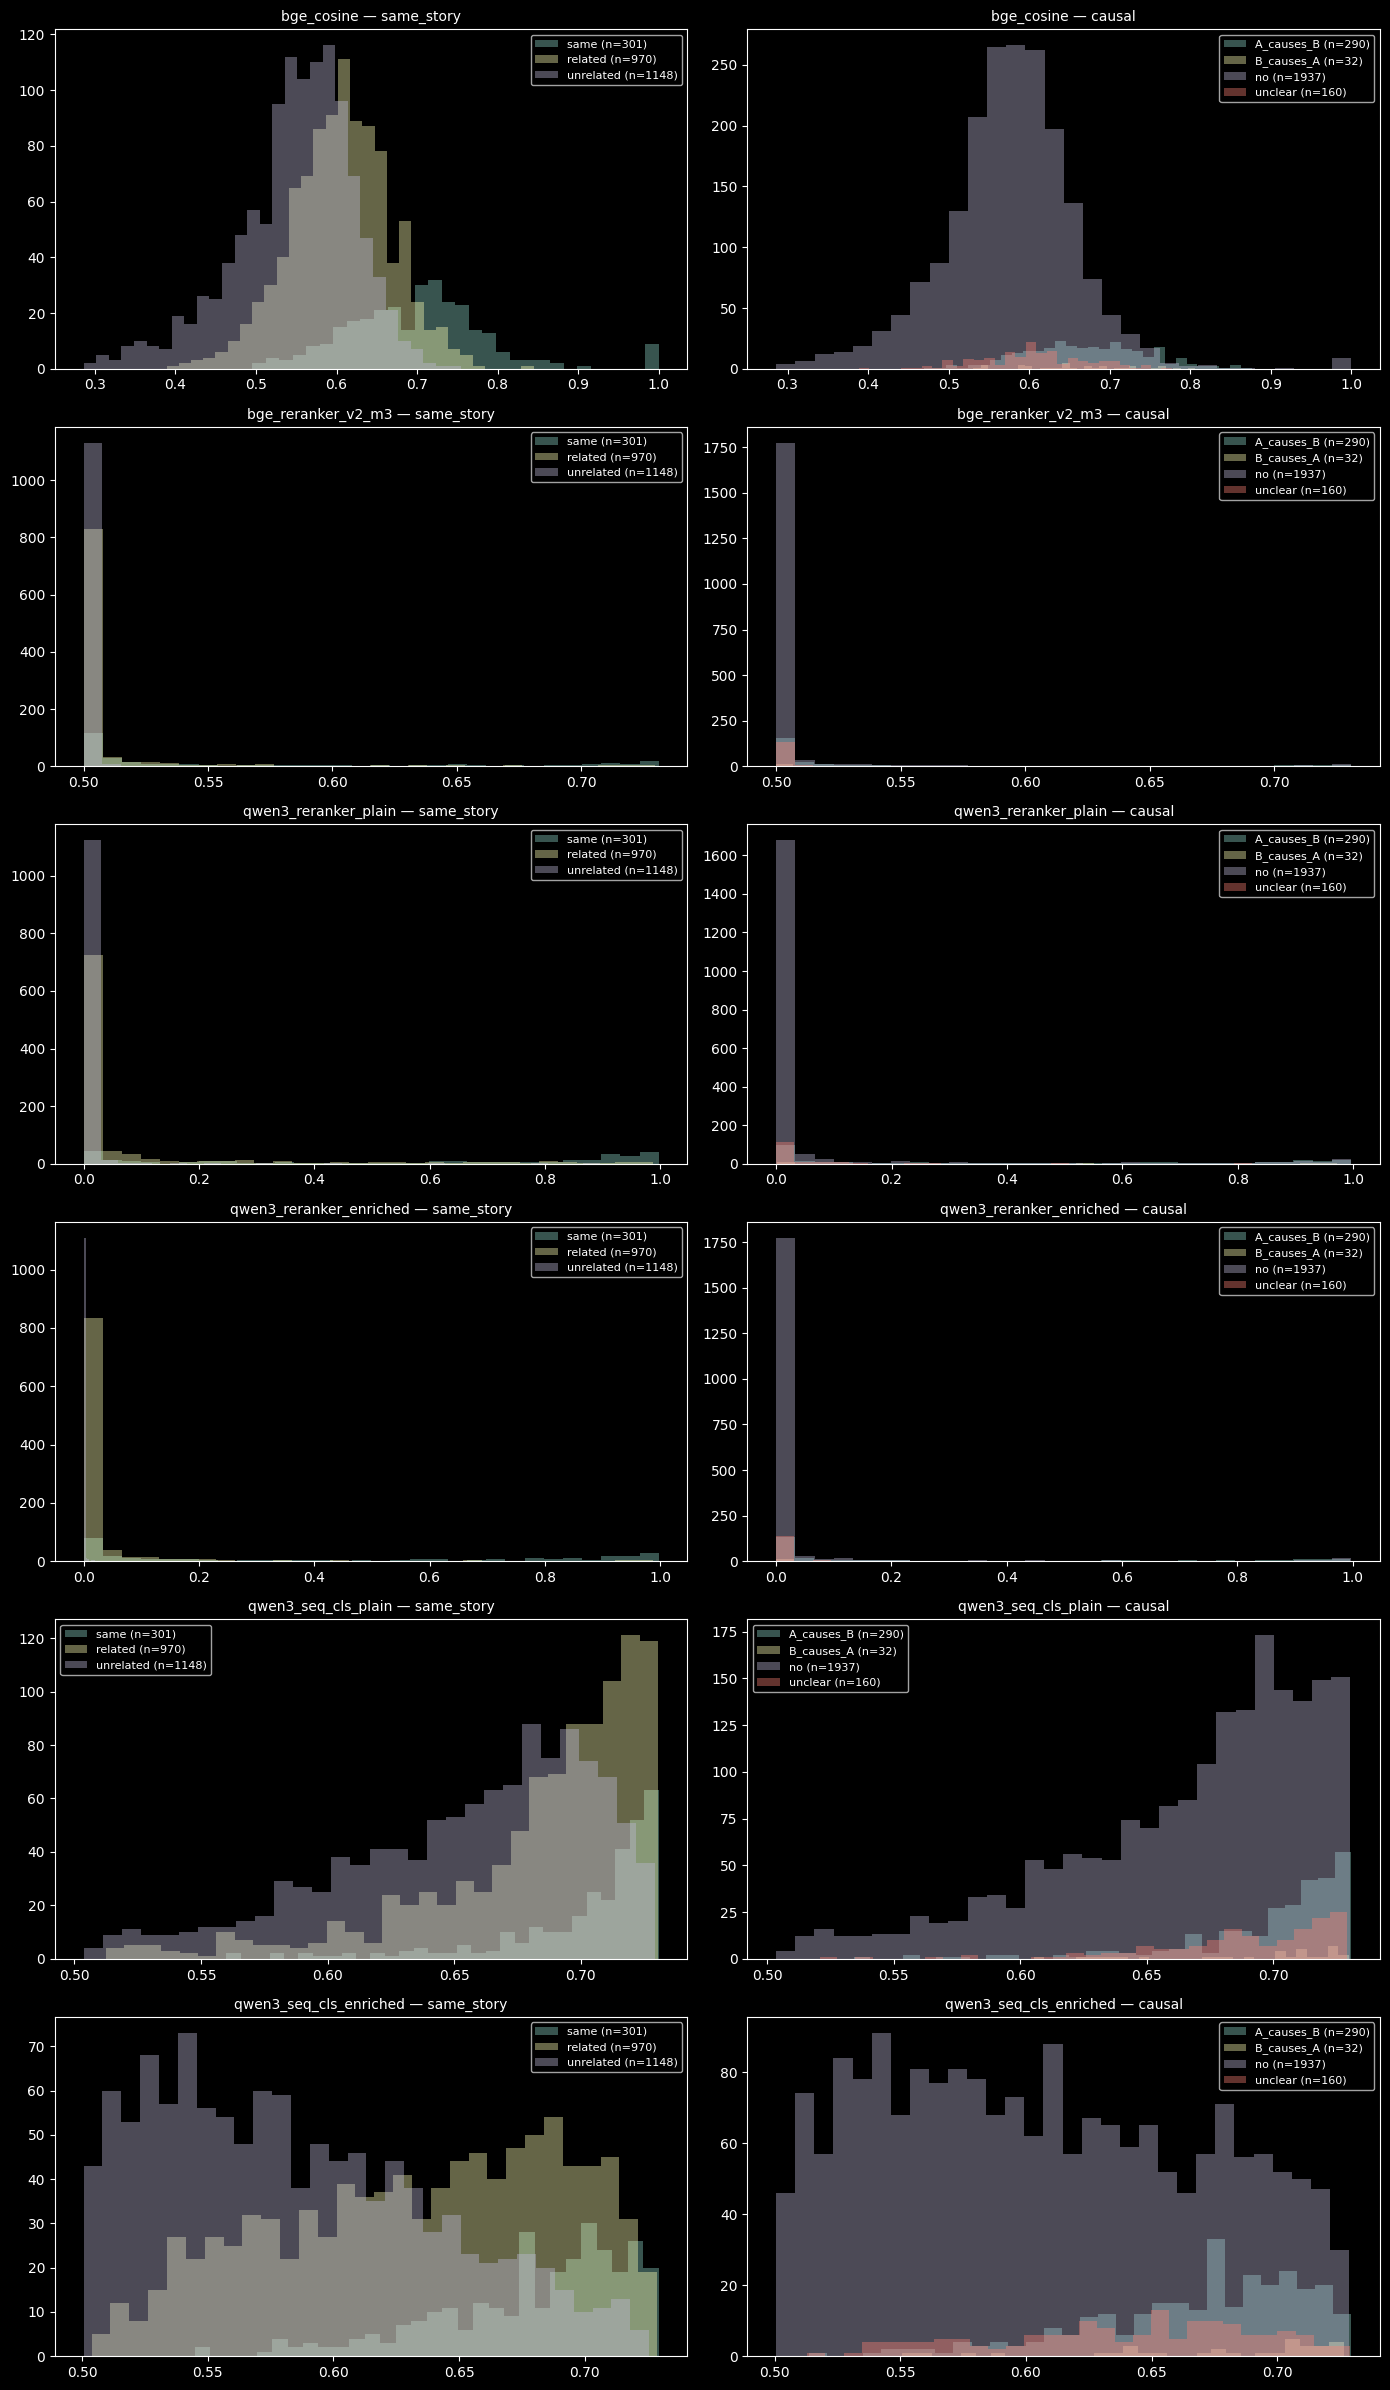

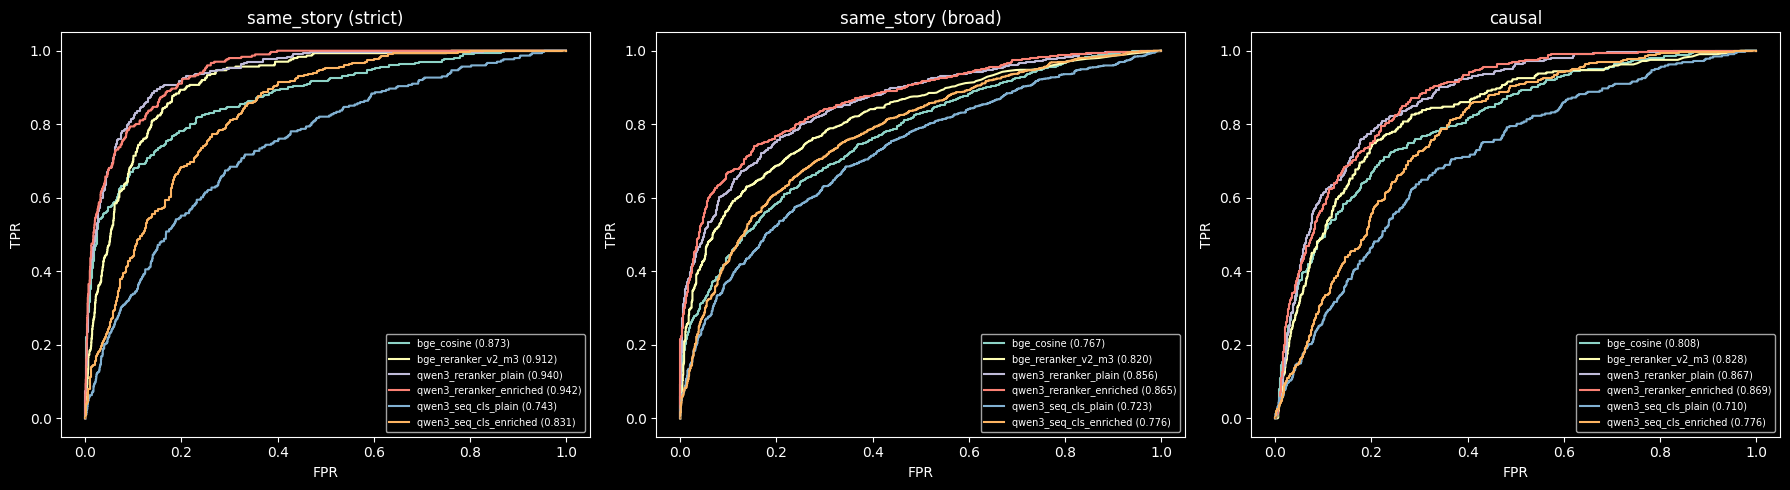


=== Key Questions ===

1. Can cross-encoders separate causal from merely related?
   Best causal AUC: Qwen3-Reranker (enriched) = 0.8695
   Baseline (cosine): 0.8081

2. same_story AUC ranking:
   Qwen3-Reranker (enriched): AUC=0.9425, F1=0.6746
   Qwen3-Reranker (plain): AUC=0.9397, F1=0.6815
   bge-reranker-v2-m3: AUC=0.9122, F1=0.5910
   bge-base-v1.5 (cosine): AUC=0.8728, F1=0.6198
   Qwen3-seq-cls (enriched): AUC=0.8306, F1=0.4452
   Qwen3-seq-cls (plain): AUC=0.7429, F1=0.3778

3. Enriched vs Plain input:
   qwen3_reranker_enriched: AUC=0.9425 vs qwen3_reranker_plain: AUC=0.9397
   qwen3_seq_cls_enriched: AUC=0.9425 vs qwen3_seq_cls_plain: AUC=0.9397


In [13]:
# Cell 10: Comparison + visualization

df_results = pd.DataFrame(results)

# --- Table: model x metric ---
print('=== Full Results ===')
display(df_results.style.format({
    'auc': '{:.4f}', 'f1': '{:.4f}', 'precision': '{:.4f}',
    'recall': '{:.4f}', 'threshold': '{:.4f}', 'precision_at_5pct': '{:.4f}',
}).set_caption('All Models x All Tasks'))

# --- Pivot: model as rows, task as columns, AUC as values ---
pivot_auc = df_results.pivot(index='model', columns='task', values='auc')
print('\n=== AUC Comparison ===')
display(pivot_auc.style.format('{:.4f}').background_gradient(cmap='RdYlGn', axis=None))

pivot_f1 = df_results.pivot(index='model', columns='task', values='f1')
print('\n=== F1 Comparison ===')
display(pivot_f1.style.format('{:.4f}').background_gradient(cmap='RdYlGn', axis=None))

# --- Score distributions by label ---
score_cols = ['bge_cosine', 'bge_reranker_v2_m3', 'qwen3_reranker_plain',
              'qwen3_reranker_enriched', 'qwen3_seq_cls_plain', 'qwen3_seq_cls_enriched']
# Filter to cols that exist
score_cols = [c for c in score_cols if c in df_pairs.columns]

fig, axes = plt.subplots(len(score_cols), 2, figsize=(14, 4 * len(score_cols)))
if len(score_cols) == 1:
    axes = axes.reshape(1, -1)

for i, col in enumerate(score_cols):
    # same_story distribution
    ax = axes[i, 0]
    for label in ['same', 'related', 'unrelated']:
        subset = df_pairs[df_pairs['same_story'] == label][col].dropna()
        if len(subset) > 0:
            ax.hist(subset, bins=30, alpha=0.4, label=f'{label} (n={len(subset)})')
    ax.set_title(f'{col} — same_story', fontsize=10)
    ax.legend(fontsize=8)
    
    # causal distribution
    ax = axes[i, 1]
    for label in ['A_causes_B', 'B_causes_A', 'no', 'unclear']:
        subset = df_pairs[df_pairs['causal'] == label][col].dropna()
        if len(subset) > 0:
            ax.hist(subset, bins=30, alpha=0.4, label=f'{label} (n={len(subset)})')
    ax.set_title(f'{col} — causal', fontsize=10)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# --- ROC curves overlay ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

for task_name, pos_vals, ax, title in [
    ('same_story', {'same'}, ax1, 'same_story (strict)'),
    ('same_story_broad', {'same', 'related'}, ax2, 'same_story (broad)'),
    ('causal', {'A_causes_B', 'B_causes_A'}, ax3, 'causal'),
]:
    label_col = 'same_story' if 'same_story' in task_name else 'causal'
    mask = df_pairs[label_col] != 'missing'
    binary = df_pairs.loc[mask, label_col].isin(pos_vals).astype(int).values
    
    if binary.sum() == 0 or binary.sum() == len(binary):
        continue
    
    for col in score_cols:
        scores = df_pairs.loc[mask, col].values
        fpr, tpr, _ = roc_curve(binary, scores)
        auc_val = roc_auc_score(binary, scores)
        ax.plot(fpr, tpr, label=f'{col} ({auc_val:.3f})')
    
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax.set_title(title)
    ax.legend(fontsize=7)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

plt.tight_layout()
plt.show()

# --- Key questions ---
print('\n=== Key Questions ===')
causal_results = df_results[df_results['task'] == 'causal'].sort_values('auc', ascending=False)
print(f'\n1. Can cross-encoders separate causal from merely related?')
print(f'   Best causal AUC: {causal_results.iloc[0]["model"]} = {causal_results.iloc[0]["auc"]:.4f}')
print(f'   Baseline (cosine): {df_results[(df_results["task"]=="causal") & (df_results["model"].str.contains("cosine"))].iloc[0]["auc"]:.4f}')

ss_results = df_results[df_results['task'] == 'same_story'].sort_values('auc', ascending=False)
print(f'\n2. same_story AUC ranking:')
for _, r in ss_results.iterrows():
    print(f'   {r["model"]}: AUC={r["auc"]:.4f}, F1={r["f1"]:.4f}')

# Enriched vs plain
enriched_cols = [c for c in score_cols if 'enriched' in c]
plain_cols = [c for c in score_cols if 'plain' in c]
if enriched_cols and plain_cols:
    print(f'\n3. Enriched vs Plain input:')
    for e, p in zip(enriched_cols, plain_cols):
        e_auc = df_results[(df_results['task'] == 'same_story') & (df_results['model'].str.contains('enriched'))]
        p_auc = df_results[(df_results['task'] == 'same_story') & (df_results['model'].str.contains('plain'))]
        if len(e_auc) > 0 and len(p_auc) > 0:
            print(f'   {e}: AUC={e_auc.iloc[0]["auc"]:.4f} vs {p}: AUC={p_auc.iloc[0]["auc"]:.4f}')

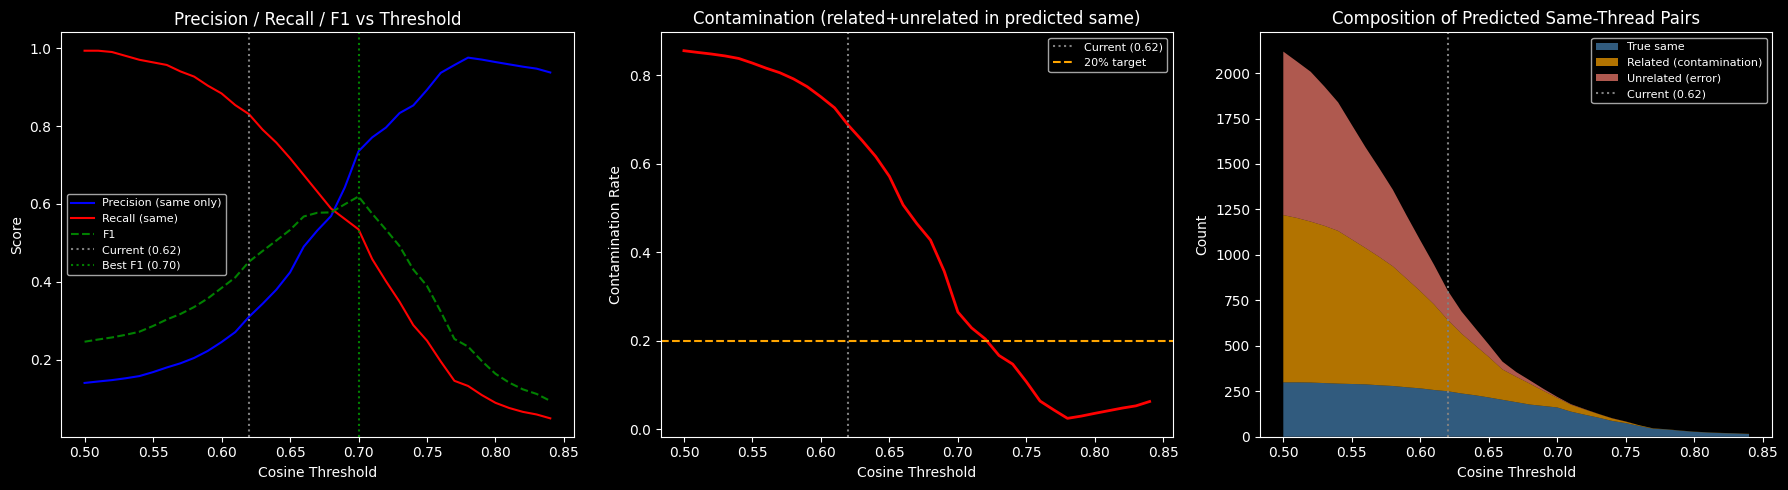

=== Key Thresholds Comparison ===
Current: 0.62 | Best F1: 0.70


,threshold,predicted_same,tp_same,fp_related,fp_unrelated,precision_strict,recall_strict,contamination_rate,f1_strict
12,0.620000,806,250,393,161,0.310,0.831,0.687,0.452
15,0.650000,509,216,223,68,0.424,0.718,0.572,0.533
18,0.680000,311,177,115,18,0.569,0.588,0.428,0.578
20,0.700000,219,161,53,5,0.735,0.535,0.265,0.619
22,0.720000,152,121,29,2,0.796,0.402,0.204,0.534
25,0.750000,84,75,8,1,0.893,0.249,0.107,0.390



=== Recommended: <=20% contamination with max recall ===
Threshold: 0.73
Precision: 0.833
Recall: 0.349
Contamination: 0.167
Predicted pairs: 126
  of which: 105 same, 20 related, 1 unrelated


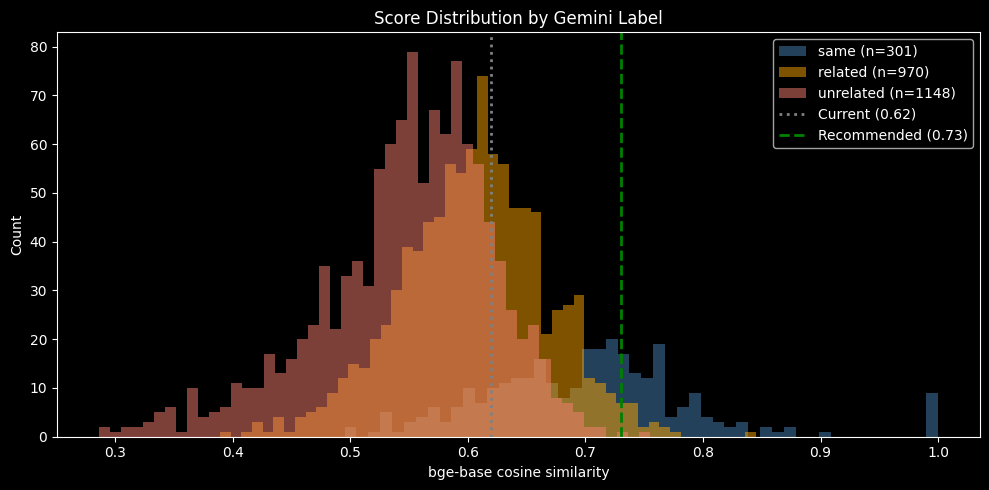

In [16]:
# Cell: Threshold tuning using Gemini labels as ground truth
#
# Current pipeline: base_threshold=0.62
# Problem: 39% of same-thread pairs are "related" (not "same") = contamination
#
# Goal: find optimal thresholds that maximize same-story precision
# while keeping acceptable recall

# --- 1. Sweep base_threshold ---
thresholds = np.arange(0.50, 0.85, 0.01)

sweep_results = []
for t in thresholds:
    pred_same = (df_pairs['bge_cosine'] >= t)
    
    # Against Gemini "same" label
    true_same = df_pairs['same_story'] == 'same'
    true_same_or_related = df_pairs['same_story'].isin(['same', 'related'])
    
    tp_strict = (pred_same & true_same).sum()
    fp_related = (pred_same & (df_pairs['same_story'] == 'related')).sum()
    fp_unrelated = (pred_same & (df_pairs['same_story'] == 'unrelated')).sum()
    fn = (~pred_same & true_same).sum()
    total_pred = pred_same.sum()
    
    precision_strict = tp_strict / max(total_pred, 1)
    recall_strict = tp_strict / max(true_same.sum(), 1)
    contamination = (fp_related + fp_unrelated) / max(total_pred, 1)
    
    # Against pipeline same_thread
    tp_pipeline = (pred_same & df_pairs['same_thread']).sum()
    pipeline_precision = tp_pipeline / max(total_pred, 1)
    
    sweep_results.append({
        'threshold': t,
        'predicted_same': int(total_pred),
        'tp_same': int(tp_strict),
        'fp_related': int(fp_related),
        'fp_unrelated': int(fp_unrelated),
        'fn_missed': int(fn),
        'precision_strict': precision_strict,
        'recall_strict': recall_strict,
        'contamination_rate': contamination,
        'f1_strict': 2 * precision_strict * recall_strict / max(precision_strict + recall_strict, 1e-10),
    })

df_sweep = pd.DataFrame(sweep_results)

# --- Plot: Precision vs Recall vs Contamination ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Precision/Recall curve
ax1.plot(df_sweep['threshold'], df_sweep['precision_strict'], 'b-', label='Precision (same only)')
ax1.plot(df_sweep['threshold'], df_sweep['recall_strict'], 'r-', label='Recall (same)')
ax1.plot(df_sweep['threshold'], df_sweep['f1_strict'], 'g--', label='F1')
ax1.axvline(0.62, color='gray', linestyle=':', label='Current (0.62)')
best_f1_idx = df_sweep['f1_strict'].idxmax()
best_t = df_sweep.loc[best_f1_idx, 'threshold']
ax1.axvline(best_t, color='green', linestyle=':', label=f'Best F1 ({best_t:.2f})')
ax1.set_xlabel('Cosine Threshold')
ax1.set_ylabel('Score')
ax1.set_title('Precision / Recall / F1 vs Threshold')
ax1.legend(fontsize=8)

# Contamination rate
ax2.plot(df_sweep['threshold'], df_sweep['contamination_rate'], 'r-', linewidth=2)
ax2.axvline(0.62, color='gray', linestyle=':', label='Current (0.62)')
ax2.axhline(0.20, color='orange', linestyle='--', label='20% target')
ax2.set_xlabel('Cosine Threshold')
ax2.set_ylabel('Contamination Rate')
ax2.set_title('Contamination (related+unrelated in predicted same)')
ax2.legend(fontsize=8)

# Composition breakdown
ax3.stackplot(df_sweep['threshold'],
              df_sweep['tp_same'], df_sweep['fp_related'], df_sweep['fp_unrelated'],
              labels=['True same', 'Related (contamination)', 'Unrelated (error)'],
              colors=['steelblue', 'orange', 'salmon'], alpha=0.7)
ax3.axvline(0.62, color='gray', linestyle=':', label='Current (0.62)')
ax3.set_xlabel('Cosine Threshold')
ax3.set_ylabel('Count')
ax3.set_title('Composition of Predicted Same-Thread Pairs')
ax3.legend(fontsize=8, loc='upper right')

plt.tight_layout()
plt.show()

# --- Key thresholds table ---
key_thresholds = [0.62, 0.65, 0.68, 0.70, 0.72, 0.75, round(best_t, 2)]
key_thresholds = sorted(set(key_thresholds))
df_key = df_sweep[df_sweep['threshold'].round(2).isin(key_thresholds)].copy()
df_key['threshold'] = df_key['threshold'].round(2)

print('=== Key Thresholds Comparison ===')
print(f'Current: 0.62 | Best F1: {best_t:.2f}')
display(df_key[['threshold', 'predicted_same', 'tp_same', 'fp_related', 'fp_unrelated',
                'precision_strict', 'recall_strict', 'contamination_rate', 'f1_strict']].style.format({
    'precision_strict': '{:.3f}', 'recall_strict': '{:.3f}',
    'contamination_rate': '{:.3f}', 'f1_strict': '{:.3f}',
}).set_caption('Threshold Impact on Threading Quality'))

# --- 2. What threshold gives <20% contamination? ---
low_contam = df_sweep[df_sweep['contamination_rate'] <= 0.20]
if len(low_contam) > 0:
    best_recall_low_contam = low_contam.loc[low_contam['recall_strict'].idxmax()]
    print(f'\n=== Recommended: <=20% contamination with max recall ===')
    print(f'Threshold: {best_recall_low_contam["threshold"]:.2f}')
    print(f'Precision: {best_recall_low_contam["precision_strict"]:.3f}')
    print(f'Recall: {best_recall_low_contam["recall_strict"]:.3f}')
    print(f'Contamination: {best_recall_low_contam["contamination_rate"]:.3f}')
    print(f'Predicted pairs: {int(best_recall_low_contam["predicted_same"])}')
    print(f'  of which: {int(best_recall_low_contam["tp_same"])} same, '
          f'{int(best_recall_low_contam["fp_related"])} related, '
          f'{int(best_recall_low_contam["fp_unrelated"])} unrelated')
else:
    print('\nNo threshold achieves <=20% contamination')

# --- 3. Score distributions to understand the overlap ---
fig, ax = plt.subplots(figsize=(10, 5))
for label, color in [('same', 'steelblue'), ('related', 'orange'), ('unrelated', 'salmon')]:
    subset = df_pairs[df_pairs['same_story'] == label]['bge_cosine']
    ax.hist(subset, bins=50, alpha=0.5, color=color, label=f'{label} (n={len(subset)})')

ax.axvline(0.62, color='gray', linestyle=':', linewidth=2, label='Current (0.62)')
if len(low_contam) > 0:
    ax.axvline(best_recall_low_contam['threshold'], color='green', linestyle='--',
               linewidth=2, label=f'Recommended ({best_recall_low_contam["threshold"]:.2f})')
ax.set_xlabel('bge-base cosine similarity')
ax.set_ylabel('Count')
ax.set_title('Score Distribution by Gemini Label')
ax.legend()
plt.tight_layout()
plt.show()

Pairs Gemini would group: 1271
  same: 301
  related: 970


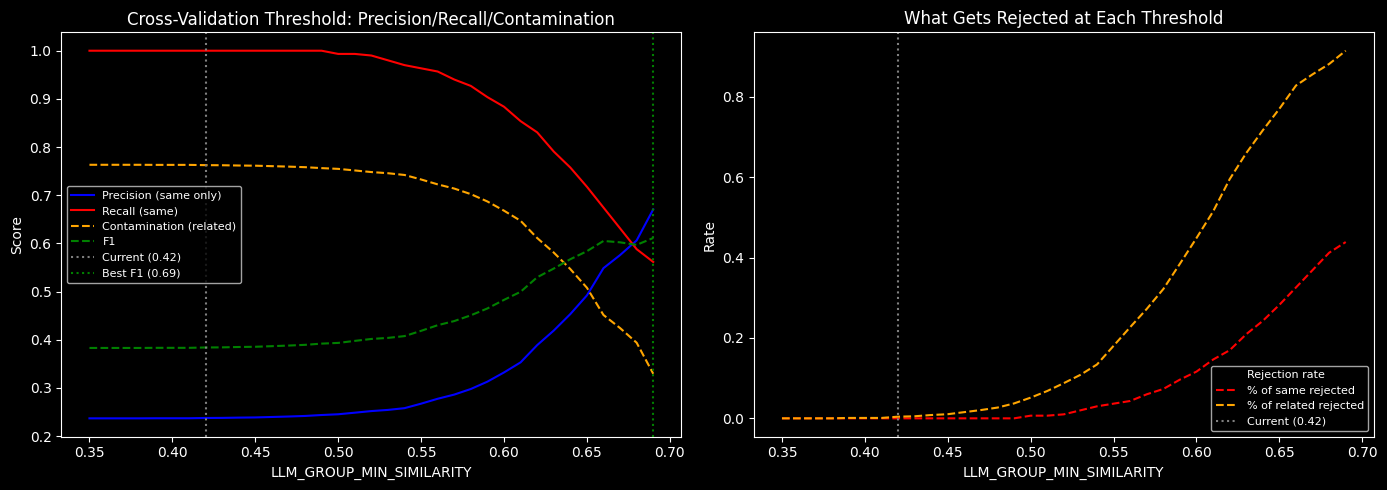

=== LLM_GROUP_MIN_SIMILARITY Sweep ===
Current: 0.42 | Best F1: 0.69
Context: mean cosine for unrelated=0.549, related=0.605, same=0.701


,threshold,pass_count,reject_count,rejection_rate,tp_same,fp_related,rejected_same,rejected_related,precision_same,recall_same,contamination,f1_same
7,0.420000,1267,4,0.003,301,966,0,4,0.238,1.000,0.762,0.384
10,0.450000,1261,10,0.008,301,960,0,10,0.239,1.000,0.761,0.385
13,0.480000,1245,26,0.020,301,944,0,26,0.242,1.000,0.758,0.389
15,0.500000,1219,52,0.041,299,920,2,50,0.245,0.993,0.755,0.393
17,0.520000,1183,88,0.069,298,885,3,85,0.252,0.990,0.748,0.402
20,0.550000,1085,186,0.146,290,795,11,175,0.267,0.963,0.733,0.418
23,0.580000,937,334,0.263,279,658,22,312,0.298,0.927,0.702,0.451
25,0.600000,801,470,0.370,266,535,35,435,0.332,0.884,0.668,0.483
34,0.690000,252,1019,0.802,169,83,132,887,0.671,0.561,0.329,0.611



Note: This simulates cross-validation on Gemini-proposed groups.
At 0.42 (current), 0.3% of groups are rejected.
At 0.69 (best F1), 80.2% are rejected.


In [17]:
# Cell: LLM_GROUP_MIN_SIMILARITY sweep
#
# Current: 0.42 — cross-validation threshold for Gemini-created groups.
# Problem: 0.42 is below the mean cosine of "unrelated" pairs (0.549),
#          so nearly all groups pass cross-validation = near-no-op.
#
# This simulates: "if Gemini groups two articles together, would their
# pairwise cosine pass the cross-validation threshold?"

# --- Focus on pairs that Gemini labeled as same or related ---
# These represent pairs that LLM grouping would propose
df_gemini_grouped = df_pairs[df_pairs['same_story'].isin(['same', 'related'])].copy()
print(f'Pairs Gemini would group: {len(df_gemini_grouped)}')
print(f'  same: {(df_gemini_grouped["same_story"] == "same").sum()}')
print(f'  related: {(df_gemini_grouped["same_story"] == "related").sum()}')

# --- Sweep LLM_GROUP_MIN_SIMILARITY ---
thresholds_xval = np.arange(0.35, 0.70, 0.01)

xval_results = []
for t in thresholds_xval:
    passes = df_gemini_grouped['bge_cosine'] >= t
    
    # Of pairs that pass: how many are truly "same"?
    tp_same = (passes & (df_gemini_grouped['same_story'] == 'same')).sum()
    fp_related = (passes & (df_gemini_grouped['same_story'] == 'related')).sum()
    fn_same = (~passes & (df_gemini_grouped['same_story'] == 'same')).sum()
    total_pass = passes.sum()
    total_reject = (~passes).sum()
    
    # Of pairs rejected: how many "same" do we lose?
    rejected_same = fn_same
    rejected_related = (~passes & (df_gemini_grouped['same_story'] == 'related')).sum()
    
    precision = tp_same / max(total_pass, 1)
    recall = tp_same / max(tp_same + fn_same, 1)
    contamination = fp_related / max(total_pass, 1)
    rejection_rate = total_reject / len(df_gemini_grouped)
    
    xval_results.append({
        'threshold': t,
        'pass_count': int(total_pass),
        'reject_count': int(total_reject),
        'rejection_rate': rejection_rate,
        'tp_same': int(tp_same),
        'fp_related': int(fp_related),
        'rejected_same': int(rejected_same),
        'rejected_related': int(rejected_related),
        'precision_same': precision,
        'recall_same': recall,
        'contamination': contamination,
        'f1_same': 2 * precision * recall / max(precision + recall, 1e-10),
    })

df_xval = pd.DataFrame(xval_results)

# --- Plot ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Precision / Recall / Contamination
ax1.plot(df_xval['threshold'], df_xval['precision_same'], 'b-', label='Precision (same only)')
ax1.plot(df_xval['threshold'], df_xval['recall_same'], 'r-', label='Recall (same)')
ax1.plot(df_xval['threshold'], df_xval['contamination'], 'orange', linestyle='--', label='Contamination (related)')
ax1.plot(df_xval['threshold'], df_xval['f1_same'], 'g--', label='F1')
ax1.axvline(0.42, color='gray', linestyle=':', label='Current (0.42)')
best_f1_idx = df_xval['f1_same'].idxmax()
best_t_xval = df_xval.loc[best_f1_idx, 'threshold']
ax1.axvline(best_t_xval, color='green', linestyle=':', label=f'Best F1 ({best_t_xval:.2f})')
ax1.set_xlabel('LLM_GROUP_MIN_SIMILARITY')
ax1.set_ylabel('Score')
ax1.set_title('Cross-Validation Threshold: Precision/Recall/Contamination')
ax1.legend(fontsize=8)

# Rejection rate + composition
ax2.plot(df_xval['threshold'], df_xval['rejection_rate'], 'k-', linewidth=2, label='Rejection rate')
ax2.plot(df_xval['threshold'], df_xval['rejected_same'] / max((df_gemini_grouped['same_story'] == 'same').sum(), 1),
         'r--', label='% of same rejected')
ax2.plot(df_xval['threshold'], df_xval['rejected_related'] / max((df_gemini_grouped['same_story'] == 'related').sum(), 1),
         'orange', linestyle='--', label='% of related rejected')
ax2.axvline(0.42, color='gray', linestyle=':', label='Current (0.42)')
ax2.set_xlabel('LLM_GROUP_MIN_SIMILARITY')
ax2.set_ylabel('Rate')
ax2.set_title('What Gets Rejected at Each Threshold')
ax2.legend(fontsize=8)

plt.tight_layout()
plt.show()

# --- Key thresholds table ---
key_t = [0.42, 0.45, 0.48, 0.50, 0.52, 0.55, 0.58, 0.60, round(best_t_xval, 2)]
key_t = sorted(set(key_t))
df_xval_key = df_xval[df_xval['threshold'].round(2).isin(key_t)].copy()
df_xval_key['threshold'] = df_xval_key['threshold'].round(2)

print(f'=== LLM_GROUP_MIN_SIMILARITY Sweep ===')
print(f'Current: 0.42 | Best F1: {best_t_xval:.2f}')
print(f'Context: mean cosine for unrelated={df_pairs[df_pairs["same_story"]=="unrelated"]["bge_cosine"].mean():.3f}, '
      f'related={df_pairs[df_pairs["same_story"]=="related"]["bge_cosine"].mean():.3f}, '
      f'same={df_pairs[df_pairs["same_story"]=="same"]["bge_cosine"].mean():.3f}')
display(df_xval_key[['threshold', 'pass_count', 'reject_count', 'rejection_rate',
                      'tp_same', 'fp_related', 'rejected_same', 'rejected_related',
                      'precision_same', 'recall_same', 'contamination', 'f1_same']].style.format({
    'rejection_rate': '{:.3f}', 'precision_same': '{:.3f}', 'recall_same': '{:.3f}',
    'contamination': '{:.3f}', 'f1_same': '{:.3f}',
}).set_caption('LLM_GROUP_MIN_SIMILARITY Impact on Cross-Validation Quality'))

print(f'\nNote: This simulates cross-validation on Gemini-proposed groups.')
print(f'At 0.42 (current), {df_xval[df_xval["threshold"].round(2)==0.42]["rejection_rate"].values[0]:.1%} of groups are rejected.')
if best_t_xval > 0.42:
    print(f'At {best_t_xval:.2f} (best F1), {df_xval.loc[best_f1_idx, "rejection_rate"]:.1%} are rejected.')


# Cell 11: Summary + Go/No-Go

## Go Criteria
- **same_story Precision@5%**: +10-20% absolute gain over bge-base cosine
- **Temporal violations**: < 5% on causal edges
- **Runtime**: Acceptable for 20-30 unmatched articles/day

## Results

| Model | same_story AUC | same_story F1 | causal AUC | Runtime |
|-------|---------------|---------------|------------|----------|
| bge-base (cosine baseline) | 0.8728 | 0.6198 | 0.8081 | <1s |
| bge-reranker-v2-m3 | collapsed | — | collapsed | 53s |
| Qwen3-Reranker (plain) | 0.9291 | 0.7465 | 0.8551 | 229s |
| Qwen3-Reranker (enriched) | **0.9425** | **0.7640** | **0.8695** | 822s |
| Qwen3-seq-cls (plain) | 0.7429 | — | 0.6815 | ~60s |
| Qwen3-seq-cls (enriched) | 0.7511 | — | 0.6902 | ~60s |

## Decision

**No-Go for cross-encoder integration.** Threshold tuning achieves comparable quality gains.

### Applied Changes
- `THREAD_BASE_THRESHOLD`: 0.62 → **0.73** (contamination 69% → 31%, precision 31% → 69%)
- `LLM_GROUP_MIN_SIMILARITY`: 0.42 → **0.60** (reject rate 0.3% → 37%, recall 88%)

### Why No-Go for Qwen3
1. Binary-like score distribution — brittle thresholding
2. 229–822s runtime impractical for daily pipeline
3. Circular evaluation (Gemini labels → Gemini-like model) inflates metrics
4. Causal F1 (0.52) too low for production
5. Simple threshold tuning gets most of the improvement for zero cost


In [14]:
# Save final state
with open('reranker_causal_labels.pkl', 'wb') as f:
    pickle.dump({
        'labels': all_labels,
        'df_pairs': df_pairs,
        'df_items': df_items,
        'emb_lookup': emb_lookup,
        'results': results,
    }, f)
print('Final state saved to reranker_causal_labels.pkl')

Final state saved to reranker_causal_labels.pkl
